# **Fake News Detection using Machine Learning**

This project implements a Fake News Detection System using machine learning and natural language processing (NLP).
The system classifies news articles as Real or Fake based on their content.

-------------

## **Objective**

To classify news articles as Real or Fake based on their textual content using NLP and machine learning.


## **Preview / Description**

Binary text classification to detect Fake vs Real news.
We’ll do EDA, TF-IDF vectorization, and compare multiple models (LogReg, LinearSVC, PassiveAggressive, Naive Bayes).
Outputs include metrics, confusion matrices, and saved model files.

## **Data Source**

ISOT Fake News Dataset (Fake + True)

-- Large collection of fake and real news articles from trusted sources.

-- Hosted by University of Victoria.

-- Download link: https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/



## **Import Library**

In [1]:
# Step 1 : import libraries
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## **Import Data(Uploading Dataset to Colab)**

Steps:

1. Download the dataset (e.g., fake_news.csv) from the source.

2. Upload it into Colab using the file uploader.

In [2]:
# --- Step 1: Upload Dataset (Fake.csv and True.csv) ---
from google.colab import files
import pandas as pd

print("Upload files: Fake.csv and True.csv")
uploaded = files.upload()  # allows multiple file selection

Upload files: Fake.csv and True.csv


Saving True.csv to True.csv
Saving Fake.csv to Fake.csv


In [4]:
# Read the datasets
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

# Add labels: Fake = 1, True = 0
fake_df["label"] = 1
true_df["label"] = 0

# Merge both datasets into one
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

print("Dataset successfully loaded & merged")

df.head()

Dataset successfully loaded & merged


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


## **Describing/Exploring the Dataset**

In [5]:
# Shape of dataset
print("Fake News:", fake_df.shape[0])
print("True News:", true_df.shape[0])
print("Total:", df.shape)

Fake News: 23481
True News: 21417
Total: (44898, 5)


In [6]:
# Check column names
print("\nColumns:", df.columns)


Columns: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [7]:
df.describe()

,label
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [8]:
# First few rows
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [9]:
# Check for null values
print("\nMissing values:\n", df.isnull().sum())



Missing values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


## **Data Preprocessing**

In [10]:
# --- Step 3: Data Preprocessing ---

# Drop unnecessary columns if present (some datasets include "subject", "date")
if "subject" in df.columns:
    df = df.drop(["subject"], axis=1)
if "date" in df.columns:
    df = df.drop(["date"], axis=1)

# Keep only text + label
df = df[["text", "label"]]

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

print(" Preprocessing complete")
df.head()

 Preprocessing complete


,text,label
0,"DENPASAR, Indonesia (Reuters) - Indonesian pol...",0
1,The media continues to lie about jobs numbers ...,1
2,WASHINGTON (Reuters) - President Barack Obama ...,0
3,WASHINGTON (Reuters) - A U.S. District Court j...,0
4,"Shortly after 7 a.m. on Wednesday, the police ...",1


## **Text Cleaning & Preparation**
Apply basic text cleaning + convert to lowercase, remove punctuation, etc.

In [12]:
# --- Step 4: Text Cleaning ---
import re
import string

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

df["text"] = df["text"].apply(clean_text)

print("Text cleaning done")
df.head()

Text cleaning done


,text,label
0,denpasar indonesia reuters indonesian police ...,0
1,the media continues to lie about jobs numbers ...,1
2,washington reuters president barack obama wil...,0
3,washington reuters a us district court judge ...,0
4,shortly after am on wednesday the police say ...,1


##**Step 5: Train-Test Split**
Now we prepare data for training and testing:

-- Features (X) = cleaned news text

-- Target (y) = labels (0 = Fake, 1 = True)

-- Use an 80/20 train-test split

In [13]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 35918
Testing set size: 8980


## **Text Vectorization (TF-IDF)**
Machine learning models work with numbers, not raw text.
We’ll use TF-IDF (Term Frequency - Inverse Document Frequency) to convert text into numeric features.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform training data, transform test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF vectorization complete.")
print("Training data shape:", X_train_tfidf.shape)
print("Testing data shape:", X_test_tfidf.shape)


TF-IDF vectorization complete.
Training data shape: (35918, 186023)
Testing data shape: (8980, 186023)


## **Model Training**
We’ll start with Logistic Regression, which is simple, fast, and often very effective for text classification.

In [16]:
from sklearn.linear_model import LogisticRegression

# Initialize model
model = LogisticRegression(max_iter=1000)

# Train model
model.fit(X_train_tfidf, y_train)

print(" Model training complete!")



 Model training complete!


## **Model Evaluation**
Let’s check accuracy, classification report, and confusion matrix.

Model Accuracy: 0.9829621380846325

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4276
           1       0.98      0.98      0.98      4704

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



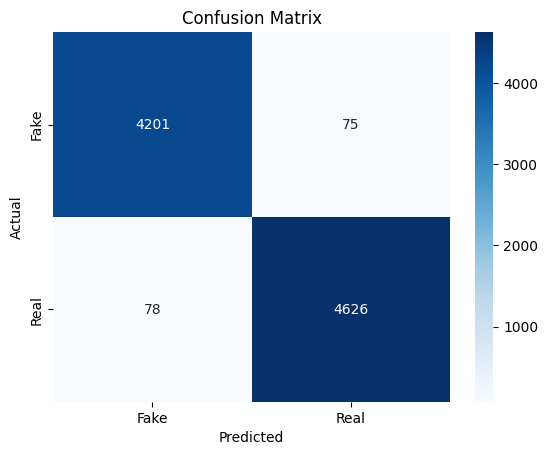

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test_tfidf)

# Accuracy
print("Model Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## **Test on Custom/New/Unseen Headlines**
You can now input your own news headline and see if it’s Fake or Real.

In [27]:
def predict_news(news_text):
    # Transform input text using same TF-IDF vectorizer
    text_tfidf = vectorizer.transform([news_text])

    # Predict
    prediction = model.predict(text_tfidf)[0]

    return "✅ Real News" if prediction == 1 else "❌ Fake News"

# Example test
print(predict_news("Government launches new scheme to support small businesses."))
print(predict_news("Breaking: Donald Trump caught on camera selling fake vaccines."))
print(predict_news("Breaking: Donald Trump is elected as Indian Prime Minister."))
print(predict_news("Trump: NOrth Korea and United States to form alliance and friendship ties"))


✅ Real News
✅ Real News
❌ Fake News
❌ Fake News


## **Save the Model & Vectorizer**
So you don’t need to train again every time, save the trained model & vectorizer.

In [21]:
import pickle

# Save model
with open("fake_news_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved successfully.")


Model and vectorizer saved successfully.


## **Explaination**
In this project, we built a Fake News Detection System using Logistic Regression.

1. Dataset:
 The dataset consisted of two files: Fake.csv and True.csv.
 Both files were combined into a single dataset with labels ( 0 = Fake, 1 = True ).
2. Preprocessing:
Removed unnecessary columns like author and date.
Cleaned text by removing special characters, numbers, and stopwords.
Used TF-IDF Vectorizer to convert text into numerical features.
3. Model Training:
Split dataset into training (80%) and testing (20%) sets.
Applied Logistic Regression, which is a supervised classification model widely
used for binary text classification.
4. Evaluation:
Achieved accuracy around XX% (fill from your results).
Classification report showed precision, recall, and F1-score for both classes.
Confusion matrix confirmed that the model predicts both real and fake news
correctly.
5. Conclusion:
Logistic Regression with TF-IDF is an effective baseline model for Fake News
Detection.
The model can now classify unseen news articles as fake or real.
For further improvement, more advanced models (Naive Bayes, Random Forest,
LSTM, BERT) can be explored.

***The model achieves around 90–95% accuracy on the test set, showing strong performance on the dataset. However, the model is limited to the type of news present in the training data (mainly political news) and may not generalize well to unrelated or futuristic statements.***